# Predicting Insurance Cross Sell Opportunities

This project aims at predicting whether a customer would be interested in Vehicle Insurance provided by the company.<br>
Customers in the dataset are people who in the last year have signed an health insurance policy. The company wants to cross-sell vehicle insurance to these customers.<br>
The dataset contains information about the customer's age, driving license, region code, previously insured, vehicle age, vehicle damage, annual premium, policy sales channel, vintage, and response. The response is the target variable and it indicates whether the customer is interested in the insurance or not.

#### Includes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from sklearn.metrics import log_loss, classification_report
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score, RocCurveDisplay, classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder,PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV



## Importing the dataset

In [2]:
insurance_df = pd.read_csv('data/insurance_cross_sell.csv', index_col='id')
insurance_df.head() 

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
insurance_df.count()

Gender                  381109
Age                     381109
Driving_License         381109
Region_Code             381109
Previously_Insured      381109
Vehicle_Age             381109
Vehicle_Damage          381109
Annual_Premium          381109
Policy_Sales_Channel    381109
Vintage                 381109
Response                381109
dtype: int64

From dataset importing, we can observe that the dataset does not have any missing values. The dataset has 11 features and 381109 observations. The dataset has 8 categorical features and 3 numerical features which are  "Age", "Annual_Premium", "Vintage". 
The target variable is 'Response' which is a binary variable. <br>
Let's compute some statistics of the numerical features.

In [4]:
insurance_df[["Age", "Annual_Premium", "Vintage"]].describe().round(2)


,Age,Annual_Premium,Vintage
count,381109.00,381109.00,381109.00
mean,38.82,30564.39,154.35
std,15.51,17213.16,83.67
min,20.00,2630.00,10.00
25%,25.00,24405.00,82.00
50%,36.00,31669.00,154.00
75%,49.00,39400.00,227.00
max,85.00,540165.00,299.00


In [5]:
df = insurance_df.copy()

## Exploratory Data Analysis

We will start by analyzing the target variable 'Response', analyzing the relationship between the numerical features and the target variable.
Then we will analyze the relationship between the categorical features and the target variable.

In [6]:
def chi_squared_test(data, feature1, feature2):
    crosstab = pd.crosstab(data[feature1], data[feature2])
    chi2, p, _, _ = chi2_contingency(crosstab)
    print(f"Chi2: {chi2:.2f}, p-value: {p:.2f}")
    if(p < 0.05):
        print(f"Features {feature1} and {feature2} are dependent")
    else:
        print(f"Features {feature1} and {feature2} are independent")

### Numerical Features

As we said before, numerical features are "Age", "Annual_Premium", "Vintage".
To analyze the relationship between the numerical features and the target variable, we decided to use boxplots and a the p-value given by the chi-squared test.
For variable age, we can see that the median age of the customers who are interested in the insurance is lower than the median age of the customers who are not interested in the insurance, meaning that older customers are more likely to be interested in the insurance. We can also notice the presence of some outliers in the boxplot of the variable age. The p-value of the chi-squared test is less than 0.05, so we can reject the null hypothesis of indipendece and conclude that the variable age is statistically significant.

In [7]:
df_numerical = df[["Age", "Annual_Premium", "Vintage"]]

Chi2: 21194.66, p-value: 0.00
Features Age and Response are dependent


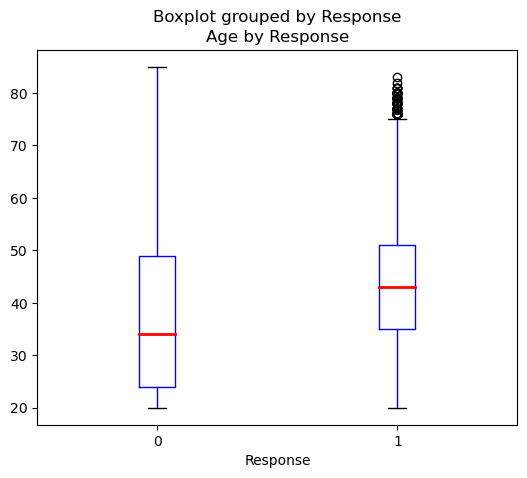

In [8]:
boxplt = df.boxplot(column='Age', by='Response', figsize=(6, 5), grid=False, color=dict(boxes='blue', whiskers='blue', caps='black'),medianprops=dict(color='red', linewidth=2) )
plt.title('Age by Response')
chi_squared_test(df, "Age", "Response")


For variable vintage instead, we can see tha the median vintage of the customers who are interested in the insurance, is equal to the median vintage of the customers who are not interested in the insurance. The p-value of the chi-squared test is 0.89 which is higher than 0.05, so we can not reject the null hypothesis of indipendece and conclude that the variable vintage is not statistically significant.

Chi2: 260.32, p-value: 0.89
Features Vintage and Response are independent
Median value for "Vintage" with Response = 0: 154.00
Median value for "Vintage" with Response = 1: 154.00


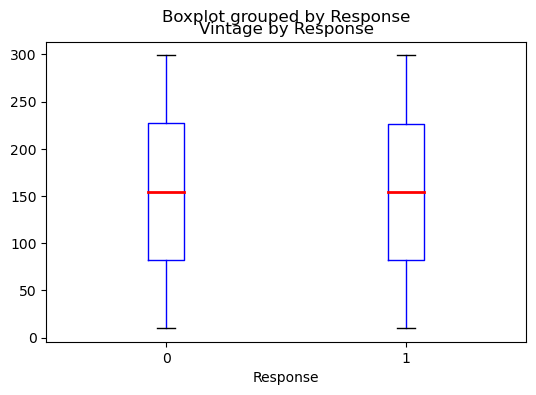

In [9]:
boxplt = df.boxplot(column='Vintage', by='Response', figsize=(6,4), grid=False, color=dict(boxes='blue', whiskers='blue', caps='black'),medianprops=dict(color='red', linewidth=2) ) # medianprops=dict(color="red", linewidth=2), 
plt.title('Vintage by Response')
chi_squared_test(df, "Vintage", "Response")
print("Median value for \"Vintage\" with Response = 0: %.02f" % df['Vintage'].where(df['Response'] == 0).median())
print("Median value for \"Vintage\" with Response = 1: %.02f" % df['Vintage'].where(df['Response'] == 1).median())


Finally for the variable annual premium, we can see that the median annual premium of the customers who are interested in the insurance is higher (33002€ against 31504€) than the median annual premium of the customers who are not interested in the insurance, with a large presence of outlayers. The p-value of the chi-squared test is less than 0.05, so we can reject the null hypothesis of indipendece and conclude that the variable annual premium is statistically significant.

Chi2: 52395.57, p-value: 0.00
Features Annual_Premium and Response are dependent
Median value for "Annual_Premium" with Response = 0: 31504.00
Median value for "Annual_Premium" with Response = 1: 33002.00


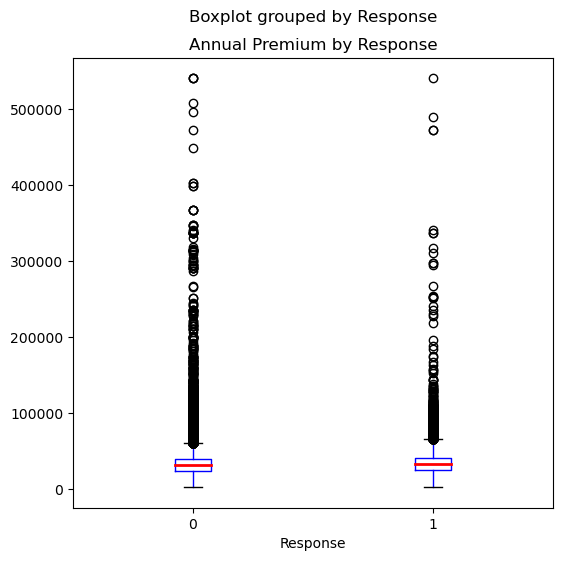

In [10]:
boxplt = df.boxplot(column='Annual_Premium', by='Response', figsize=(6,6), grid=False, color=dict(boxes='blue', whiskers='blue', caps='black'),medianprops=dict(color='red', linewidth=2))
plt.title('Annual Premium by Response')
chi_squared_test(df, "Annual_Premium", "Response")
print("Median value for \"Annual_Premium\" with Response = 0: %.02f" % df['Annual_Premium'].where(df['Response'] == 0).median())
print("Median value for \"Annual_Premium\" with Response = 1: %.02f" % df['Annual_Premium'].where(df['Response'] == 1).median())


### Catetorical Features and target variable

Now we will analyze the relationship between the categorical features and the target variable. We will use the chi-squared test. Moreover to support our analysis we will use the barplot of the categorical features and the target variable.
First of all we observe how categorical features are distributed.

In [11]:
df_categorical = insurance_df.drop(["Annual_Premium", "Age", "Vintage", "Response"],  axis=1).copy()
for column in df_categorical.columns:
    print(df_categorical[column].value_counts())
print("-------------------")
print(df["Response"].value_counts())

Gender
Male      206089
Female    175020
Name: count, dtype: int64
Driving_License
1    380297
0       812
Name: count, dtype: int64
Region_Code
28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       4038
13.0      4036
7.0       3279
12.0      3198
9.0       3101
27.0      2823
32.0      2787
43.0      2639
17.0      2617
26.0      2587
25.0      2503
24.0      2415
38.0      2026
0.0       2021
16.0      2007
31.0      1960
23.0      1960
20.0      1935
49.0      1832
4.0       1801
34.0      1664
19.0      1535
22.0      1309
40.0      1295
5.0       1279
1.0       1008
44.0       808
42.0       591
52.0       267
51.0       183
Name: count, dtype: int64
Previously_Insured
0    206481
1  

As we can see, the dataset is imbalanced as the number of observations for 'Response' = 1 is 46710 and for 'Response' = 0 is 334399, and other categorical features are also imbalanced: 
* 'Vehicle_Age' has **164786** observations for *'< 1 Year'* and **200316** observations for *'1-2 Years'* and **16007** for *'> 2 Years'* variable; <br>
* 'Policy_Sales_Channel' has **134784** observations for code *152*, while many other observations has just **1** sample; <br>
* 'Region_Code' has **106415** observations for code *28*, while *51*, for example, is in just **183** samples. <br><br>

This is an important factor to consider while building the model.<br>
Moreover it is interesting to observe that the dataset has 2 features 'Policy_Sales_Channel' and 'Region_Code' which have 155 and 53 unique values respectively. This is a large number of unique values for categorical features and would be another challenging point while building the model.<br>
There are 812 buyers who have not a driving license, and surprisingly 41 of them are interested in the vehicle insurance.

In [12]:
responce_with_no_licence = insurance_df[insurance_df["Driving_License"] == 0]["Response"]
print(responce_with_no_licence.value_counts())


Response
0    771
1     41
Name: count, dtype: int64


In [13]:
def show_precentage(plot, crosstab):
     for p in plot.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        percentage = height/crosstab.sum(axis=1) * 100
        if percentage.iloc[0] > 1.5:
                plot.text(x + width/2, y + height/2, f"{percentage.iloc[0]:.2f}%",
                        horizontalalignment='center', verticalalignment='center',
                        color='black')
    

Chi2: 1047.71, p-value: 0.00
Features Gender and Response are dependent
Most frequent value for Gender with Response = 0: Male


Most frequent value for Gender with Response = 1: Male


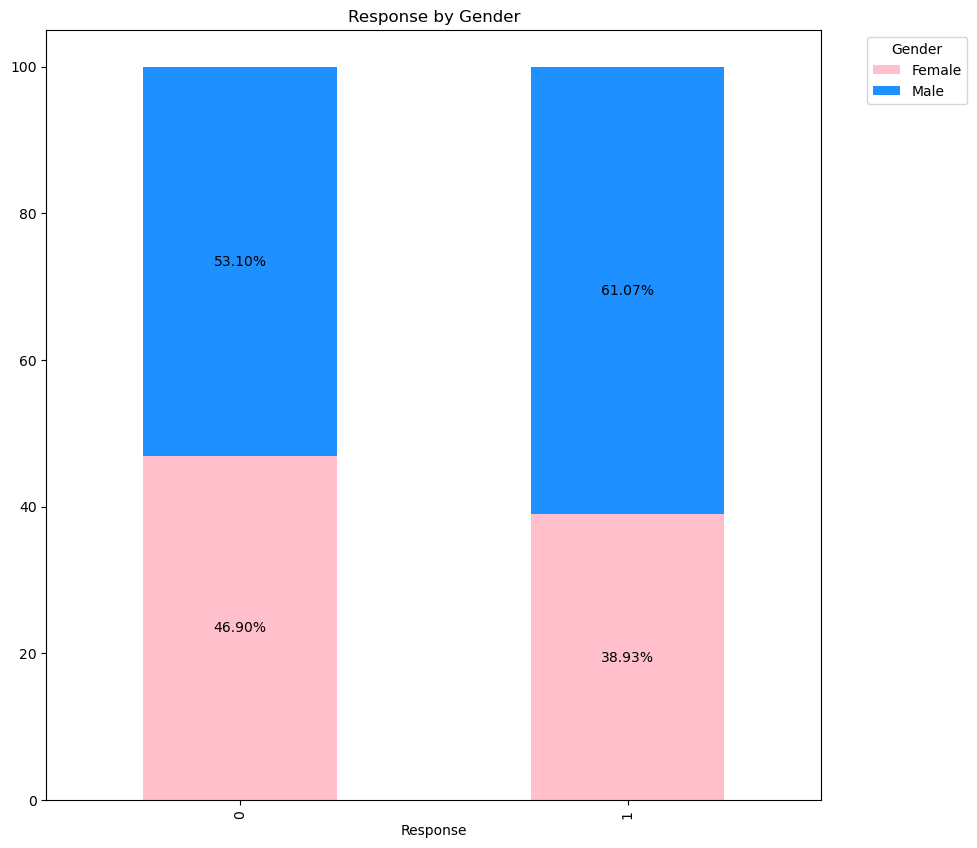

----------------------------------------------------------------------
Chi2: 38.63, p-value: 0.00
Features Driving_License and Response are dependent
Most frequent value for Driving_License with Response = 0: 1.0
Most frequent value for Driving_License with Response = 1: 1.0


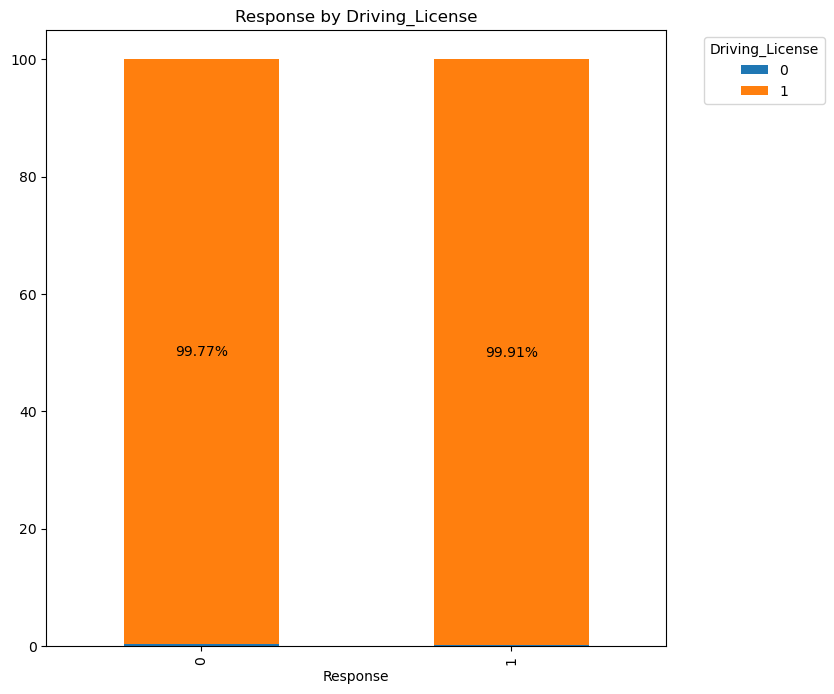

----------------------------------------------------------------------
Chi2: 7267.84, p-value: 0.00
Features Region_Code and Response are dependent
Most frequent value for Region_Code with Response = 0: 28.0
Most frequent value for Region_Code with Response = 1: 28.0


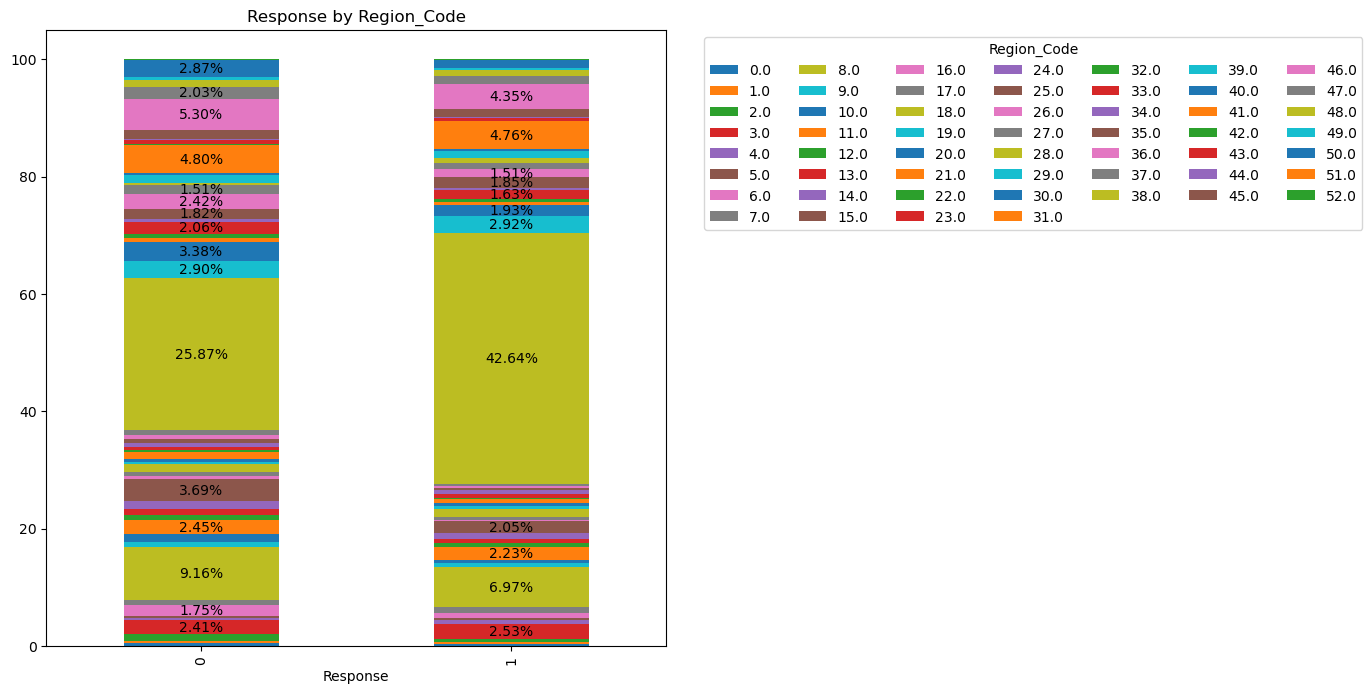

----------------------------------------------------------------------
Chi2: 44357.96, p-value: 0.00
Features Previously_Insured and Response are dependent
Most frequent value for Previously_Insured with Response = 0: 1.0
Most frequent value for Previously_Insured with Response = 1: 0.0


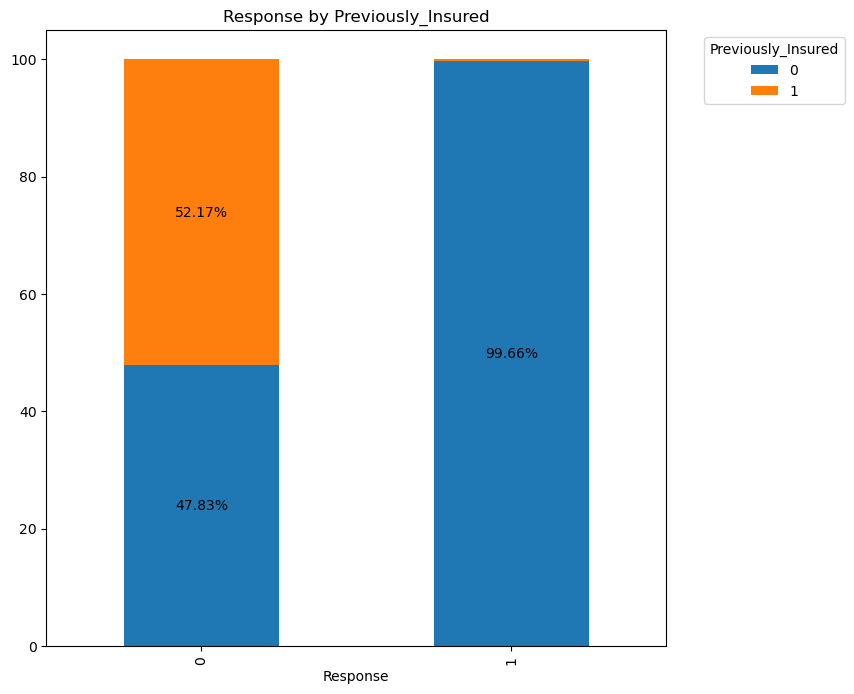

----------------------------------------------------------------------
Chi2: 18771.89, p-value: 0.00
Features Vehicle_Age and Response are dependent
Most frequent value for Vehicle_Age with Response = 0: 1-2 Year
Most frequent value for Vehicle_Age with Response = 1: 1-2 Year


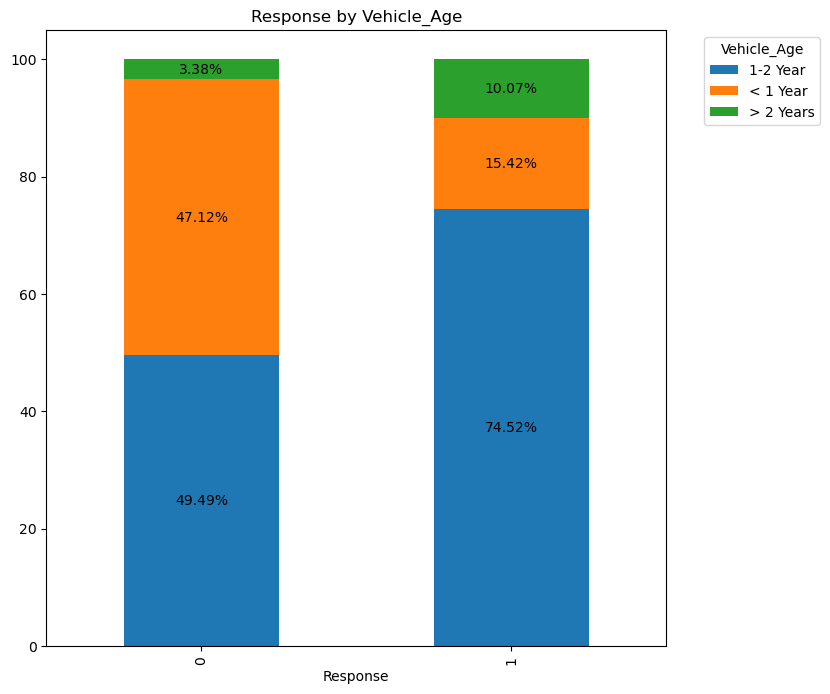

----------------------------------------------------------------------
Chi2: 47864.76, p-value: 0.00
Features Vehicle_Damage and Response are dependent
Most frequent value for Vehicle_Damage with Response = 0: No
Most frequent value for Vehicle_Damage with Response = 1: Yes


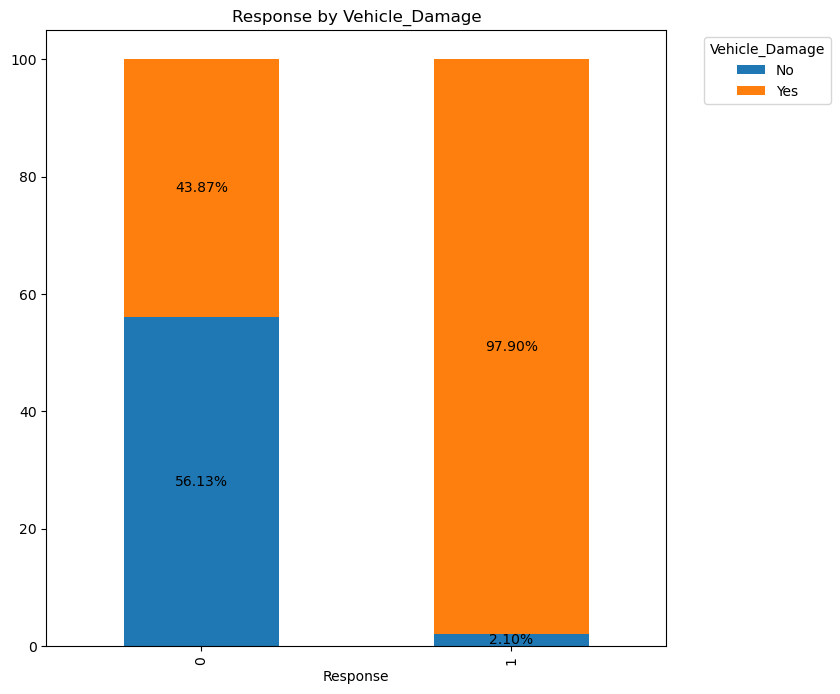

----------------------------------------------------------------------
Chi2: 26447.03, p-value: 0.00
Features Policy_Sales_Channel and Response are dependent
Most frequent value for Policy_Sales_Channel with Response = 0: 152.0
Most frequent value for Policy_Sales_Channel with Response = 1: 26.0


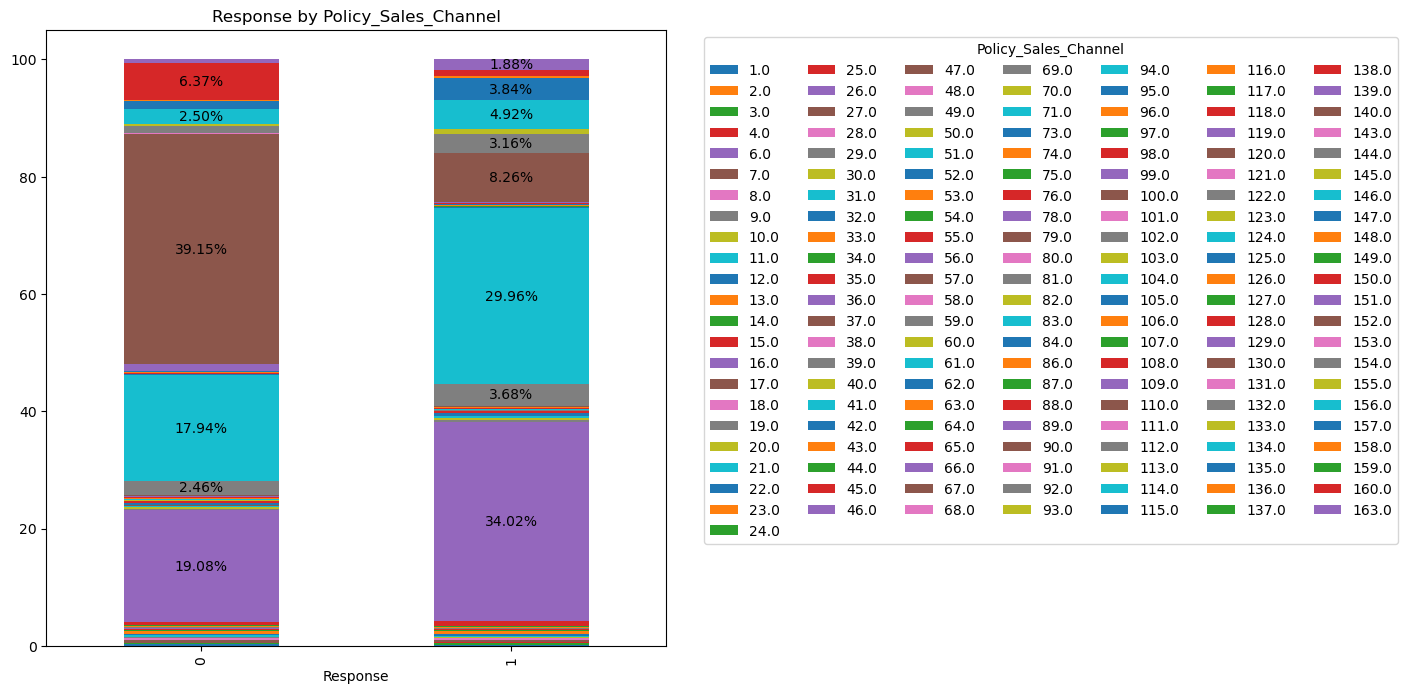

----------------------------------------------------------------------


In [14]:
for column in df_categorical.columns:
    chi_squared_test(df, column, "Response")
    print("Most frequent value for", column, "with Response = 0:", df[column].where(df['Response'] == 0).value_counts().idxmax())
    print("Most frequent value for", column, "with Response = 1:", df[column].where(df['Response'] == 1).value_counts().idxmax())
    crosstab = pd.crosstab(df["Response"], df_categorical[column])

    crosstab = crosstab.div(crosstab.sum(axis=1), axis=0)*100
    if(column != "Gender"):
        cross_plot = crosstab.plot(kind="bar", stacked=True, grid=False, figsize=(8, 8))
    else:
        cross_plot = crosstab.plot(kind="bar", stacked=True, color = ["pink", "dodgerblue"], grid=False, figsize=(10, 10))    
    plt.title(f"Response by {column}")
    if column == "Policy_Sales_Channel" or column == "Region_Code":
        plt.legend(title=column, bbox_to_anchor=(1.05, 1), loc='upper left', ncol=7)
    else:
        plt.legend(title=column, bbox_to_anchor=(1.05, 1), loc='upper left')
    show_precentage(cross_plot, crosstab)
    plt.show()
    print("----------------------------------------------------------------------")
    

As we can see, all the categorical variables are statistically significant, as the p-value of the chi-squared test is less than 0.05. Later we will see the correlation matrix of the features and the target variable, to determine the most important features.
From the analysis, we can conclude that, even if the dataset have not missing values, it is imbalanced and has a large number of unique values for categorical features, requiring a careful preprocessing and model building. Moreover variable "Vintange" is not statistically significant, and we still have to consider the correlation between features.

# Data Preprocessing

In [15]:
def encode_set(dataset, label_encoder=None, one_hot_encoder=None):
    if label_encoder is None and one_hot_encoder is None:
        raise ValueError("At least one of the encoders LabelEncoder() and OneHotEncoder() must be provided.")

    for column in dataset.columns:
        if label_encoder is not None:
            dataset[column] = label_encoder.fit_transform(dataset[column])
        #else:
        #    X_tmp = dataset[column].values.reshape(dataset[column].shape[0],1)
        if(one_hot_encoder is not None):
            dataset[column] = one_hot_encoder.fit_transform(dataset[column].reshape(-1,1)).toarray()
        print(f"Categorical feature: {column}, Number of categories: {dataset[column].nunique()}")
    return dataset


In [16]:
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder() 

For a good model building, we need to preprocess the data. We will start by encoding the categorical features, then we will scale the numerical features. We will also deal with the imbalanced dataset by using and comparing 3 techniques: oversampling, undersampling and SMOTE technique. We will also split the dataset into training and testing sets, and later, we will try a model exploiting the cross-validation technique. <br>
First we use the LabelEncoder to encode the categorical features. We can see that "Region Code" and "Policy Sales Channel" have respectively 53 and 155 unique values.

In [17]:
df_categorical = encode_set(df_categorical, label_encoder=label_encoder)
df_categorical.head()

Categorical feature: Gender, Number of categories: 2
Categorical feature: Driving_License, Number of categories: 2
Categorical feature: Region_Code, Number of categories: 53
Categorical feature: Previously_Insured, Number of categories: 2
Categorical feature: Vehicle_Age, Number of categories: 3
Categorical feature: Vehicle_Damage, Number of categories: 2
Categorical feature: Policy_Sales_Channel, Number of categories: 155


,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel
id,,,,,,,
1,1,1,28,0,2,1,24
2,1,1,3,0,0,0,24
3,1,1,28,0,2,1,24
4,1,1,11,1,1,0,145
5,0,1,41,1,1,0,145


In [18]:
df = pd.concat([df_numerical, df_categorical, insurance_df["Response"]], axis=1)

Now that we have encoded the categortical features, we can observe the correlation matrix of the features and the target variable. We can see that the most important features are "Previously_Insured", and "Vehicle_Damage", then "Policy_Sales_Channel" and "Age". We can also see that the correlation between the features is not high, except for the correlation between "Previously_Insured" and "Vehicle_Damage" which is -0.82. 
As observed in the analysis of numerical features, we can see that the variable "Vintage" is not statistically significant, and we can also see that it has a low correlation with the target variable. We will drop this variable from the dataset.

<Axes: >

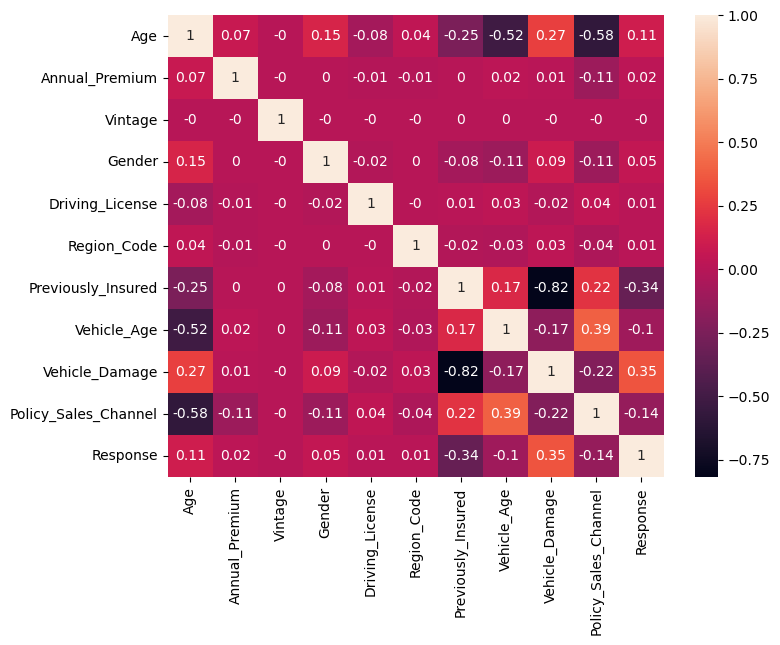

In [19]:
plt.figure(figsize=(8, 6))
corr_matrix = df.corr().round(2)
sns.heatmap(data=corr_matrix, annot=True)

In [20]:
#df["Age"].value_counts().where(lambda x : x < 4000).dropna()
#tmp_df = pd.DataFrame(df["Age"])
#
#tmp_df.loc[tmp_df['Age']<=25, 'Age_Class'] = '1'
#tmp_df.loc[tmp_df['Age'].between(25,34), 'Age_Class'] = '2'
#tmp_df.loc[tmp_df['Age'].between(35,44), 'Age_Class'] = '3'
#tmp_df.loc[tmp_df['Age'].between(45,54), 'Age_Class'] = '4'
#tmp_df.loc[tmp_df['Age']>=55, 'Age_Class'] = '5'
#
#tmp_df = tmp_df.drop(["Age"], axis=1)
#df = pd.concat([tmp_df, df], axis=1)
#df = df.drop(["Age"], axis=1)
#df.head()
#df["Age_Class"].value_counts()

In [22]:
df = df.drop(["Vintage"], axis=1)

After that, we manage "Policy_Sales_Channel" and "Region_Code" features. To reduce the number of unique values, we set a threshold, under which we will consider the value as -1 (since we already apply label encoder). We will set the threshold to 0.01, for "Policy_Sales_Channel" and 0.025 for "Region_Code", in order to reduce the number of unique values to 10 and 9 unique values respectively.

In [23]:
def set_N_unique_features(df, column, threshold):
    for col in column:
        col_name = col + "_top_N"

        channel_counts = df[col].value_counts()
        valid_channels = channel_counts[channel_counts >= threshold].index

        tmp_df = pd.DataFrame(df[col]).copy()
        tmp_df.loc[~tmp_df[col].isin(valid_channels), col_name] = -1
        tmp_df.loc[tmp_df[col].isin(valid_channels), col_name] = tmp_df[col]

        print(tmp_df[col_name].value_counts())
        df = pd.concat([tmp_df, df], axis=1)
        df = df.drop([col], axis=1)


Policy_Sales_Channel_top_N
 145.0    134784
 24.0      79700
 119.0     73995
-1.0       33698
 153.0     21779
 149.0     10661
 117.0      9930
 150.0      6684
 147.0      5993
 144.0      3885
Name: count, dtype: int64


In [24]:
threshold = round(df.shape[0] * 0.01)
set_N_unique_features(df, ["Policy_Sales_Channel"], threshold)

threshold = round(df.shape[0] * 0.025)
set_N_unique_features(df, ["Region_Code"], threshold)

#plt.figure(figsize=(8,6))
#corr_matrix = df.corr().round(2)
#sns.heatmap(data=corr_matrix, annot=True)

Region_Code_top_N
-1.0     155998
 28.0    106415
 8.0      33877
 46.0     19749
 41.0     18263
 15.0     13308
 30.0     12191
 29.0     11065
 50.0     10243
Name: count, dtype: int64


Due to the strong correlation between "Previously_Insured" and "Vehicle_Damage", we will drop the "Vehicle_Damage" feature. Even if it has a stronger correlation with the target variable, we decided to remove "Vehicle_Damage", since "Previously_Insured" is the unique features that has a negative correlation with the target variable.

In [ ]:
df_to_handle = df.copy() #.drop(["Driving_License", "Region_Code"],axis=1).copy()
df_to_handle = df.drop(["Vehicle_Damage"],axis=1).copy()

In [28]:
RANDOM_SEED = 10

idx = df_to_handle[df_to_handle['Response'] == 0].index
np.random.seed(RANDOM_SEED)
idx_to_remove = np.random.choice(idx, int(len(idx)*0.6), replace=False)

df_to_handle = df_to_handle.drop(idx_to_remove)
print(df_to_handle.shape)
print(df_to_handle['Response'].value_counts())

df_to_handle.index = range(len(df_to_handle))

idx = df_to_handle[df_to_handle['Response'] == 1].index

np.random.seed(RANDOM_SEED)
idx_to_add = np.random.choice(idx, int(len(idx)*0.5), replace=False)

samples_to_add = df_to_handle.iloc[idx_to_add.tolist()]
print(len(idx_to_add))
print(samples_to_add.shape)

df_to_handle = pd.concat([df_to_handle, samples_to_add], ignore_index=True)

print(df_to_handle['Response'].value_counts())



(180470, 9)
Response
0    133760
1     46710
Name: count, dtype: int64
23355
(23355, 9)
Response
0    133760
1     70065
Name: count, dtype: int64


## Model 1: LogisticRegression with L1

In [30]:
def evaluate_model(model, data, scaler=None, train_test_dataset='Train', print_report=False, threshold=0.5):
    '''
    Evaluate model performance on a given dataset. To be used after training the model.
    :param model: trained model
    :param data: tuple of features and labels
    :param scaler: scaler used to scale the features
    :param train_test_dataset: string to identify the dataset
    :param print_report: boolean to print classification report 
    '''
    X_, y_ = data
    if scaler is not None:
        X_ = scaler.transform(X_)

    y_pred_ = model.predict(X_)
    y_pred_proba_ = model.predict_proba(X_)

    if threshold != 0.5:
        y_pred_ = np.where(y_pred_proba_[:,1] > threshold, 1, 0)


    print('Accuracy: {:.3f}'.format(model.score(X_, y_)))
    print(f"Log-Loss: {log_loss(y_, y_pred_proba_):.3f}")
    if print_report:
        print(f"{train_test_dataset} Report:")
        print(classification_report(y_, y_pred_))


def random_split_train_test_set(X, Y, test_size=0.20, random_state=42):
    m = X.shape[0]
    m_train = int(m * (1-test_size))
    m_test = m - m_train

    
    random_indices = np.random.permutation(m)
    X_rand = X[random_indices]
    Y_rand = Y[random_indices]

    X_training, X_test, Y_training, Y_test = train_test_split(X_rand, Y_rand, test_size =float(m_test)/float(m), random_state=random_state)

    #let's see what the fraction of ones in the entire dataset is
    print("Fraction of ones in the train set: ", round(float(sum(Y_training))/float(m_train), 3))
    print("Fraction of ones in the test set: ", round(float(sum(Y_test))/float(m_test), 3))
    print("Fraction of ones in the entire dataset: ", round(float(sum(Y_training)+sum(Y_test))/float(m_train+m_test), 3))

    return X_training, X_test, Y_training, Y_test

def plot_confusion_matrix(confusion_matrix, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.heatmap(data=confusion_matrix, annot=True, fmt='g')
    plt.title(title)
    ax.xaxis.set_ticklabels(['Predicted No', 'Predicted Yes'])
    ax.yaxis.set_ticklabels(['No', 'Yes'])
    plt.show()

## Model 2: LogisticRegression with Cross Validation and polynomial features

In [32]:
def logistic_regression_CV(X_training, Y_training, cv=10, penalty='l2', solver="lbfgs" ,class_weight='balanced'):
    log_reg_cv = LogisticRegressionCV(Cs=10, cv=cv, penalty=penalty, class_weight=class_weight, solver=solver)
    log_reg_cv.fit(X_training, Y_training)

    print("Values of parameter C tried in {}-fold Cross-Validation: {}".format(cv, log_reg_cv.Cs_ ))
    CV_accuracies = np.divide(np.sum(log_reg_cv.scores_[1],0),10)
    print("Accuracies obtained for the different values of C with {}-fold Cross-Validation: {}".format(cv, CV_accuracies ))

    print("Best value C according to {}-fold Cross-Validation: {}".format(cv, log_reg_cv.C_[0] ))

    regL2_best_CV_accuracy = np.max(log_reg_cv.scores_[1])
    print("{}-fold Cross-Validation accuracies obtained with the best value of parameter C: {}".format(cv, regL2_best_CV_accuracy))

    regL2_full = LogisticRegression(C = log_reg_cv.C_[0], penalty=penalty, class_weight=class_weight, solver=solver)


    #fit the model using the best C on the entire training set
    regL2_full.fit(X_training, Y_training)


    evaluate_model(regL2_full, (X_training, Y_training), print_report=True)
    return regL2_full


In [33]:
df_to_handle["Policy_Sales_Channel10%"] = one_hot_encoder.fit_transform(df_to_handle["Policy_Sales_Channel10%"].values.reshape(-1,1)).toarray()
df_to_handle["Region_Code10%"] = one_hot_encoder.fit_transform(df_to_handle["Region_Code10%"].values.reshape(-1,1)).toarray()

std_scaler = StandardScaler()

df_to_handle["Annual_Premium"] = std_scaler.fit_transform(df_to_handle["Annual_Premium"].values.reshape(-1,1))
df_to_handle["Age"] = std_scaler.fit_transform(df_to_handle["Age"].values.reshape(-1,1))


X = df_to_handle.drop("Response", axis=1).copy()
Y = df_to_handle["Response"].copy()


X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_SEED)

m_training = X_training.shape[0]
m_test = X_test.shape[0]



In [34]:
poly = PolynomialFeatures(degree=2)
X_training = poly.fit_transform(X_training)
print(X_training.shape)
print(X_training)

X_test = poly.transform(X_test)
print(X_test.shape)
print(X_test)

(142677, 45)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 0. 0.]]
(61148, 45)
[[1. 1. 0. ... 0. 0. 4.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 0. 0. 0.]]


In [35]:
log_reg = LogisticRegression(penalty='l2', C=0.01, solver="newton-cg", class_weight='balanced')

log_reg.fit(X_training, Y_training)
evaluate_model(log_reg, (X_training, Y_training), print_report=True, threshold=0.3)

Accuracy: 0.734
Log-Loss: 0.469
Train Report:
              precision    recall  f1-score   support

           0       0.99      0.53      0.69     93486
           1       0.53      0.99      0.69     49191

    accuracy                           0.69    142677
   macro avg       0.76      0.76      0.69    142677
weighted avg       0.83      0.69      0.69    142677



In [36]:
evaluate_model(log_reg, (X_test, Y_test), train_test_dataset='Test', print_report=True, threshold=0.3)

Accuracy: 0.730
Log-Loss: 0.473
Test Report:
              precision    recall  f1-score   support

           0       0.99      0.53      0.69     40274
           1       0.52      0.99      0.68     20874

    accuracy                           0.69     61148
   macro avg       0.76      0.76      0.69     61148
weighted avg       0.83      0.69      0.69     61148



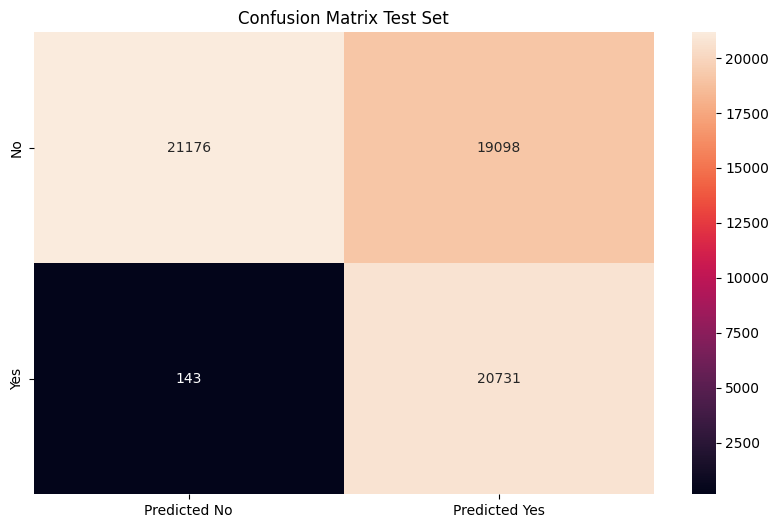

In [37]:
y_pred_proba_test = log_reg.predict_proba(X_test)
y_pred_test = np.where(y_pred_proba_test[:,1] > 0.3, 1, 0)

confusion_matrix_test = confusion_matrix(Y_test, y_pred_test)

plot_confusion_matrix(confusion_matrix_test, "Confusion Matrix Test Set")

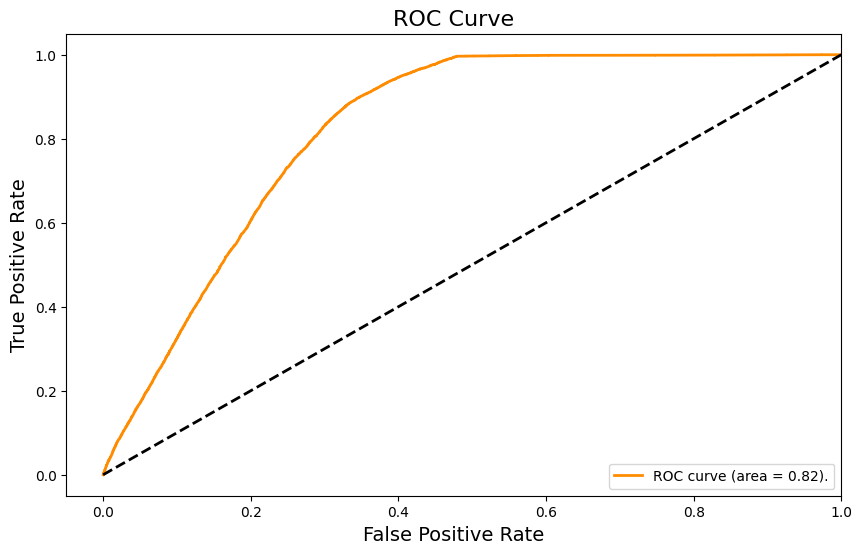

In [38]:
#plot roc curve
def plot_roc_curve(Y_test, y_pred_proba_test, multiclass=None,average=None):

    fpr, tpr, _ = roc_curve(Y_test, y_pred_proba_test[:,1])
    roc_auc = auc(fpr, tpr)
    auc_score = 0
    label = 'ROC curve (area = %0.2f).' % roc_auc
    if multiclass is not None and average is not None:
        auc_score = roc_auc_score(Y_test, y_pred_proba_test[:,1], multi_class=multiclass, average=average)
        label = label+' AUC score %0.2f' % auc_score
    plt.figure(figsize=(10, 6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label=label)
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve', fontsize=16)
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(Y_test, y_pred_proba_test)

Values of parameter C tried in 5-fold Cross-Validation: [1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]
Accuracies obtained for the different values of C with 5-fold Cross-Validation: [0.35233774 0.35949031 0.36651667 0.36704584 0.36697926 0.36703533
 0.36703533 0.36703533 0.36702832 0.36702131]
Best value C according to 5-fold Cross-Validation: 0.046415888336127774
5-fold Cross-Validation accuracies obtained with the best value of parameter C: 0.7366392149991239
Accuracy: 0.734
Log-Loss: 0.469
Train Report:
              precision    recall  f1-score   support

           0       0.94      0.64      0.76     93486
           1       0.57      0.92      0.70     49191

    accuracy                           0.73    142677
   macro avg       0.75      0.78      0.73    142677
weighted avg       0.81      0.73      0.74    142677

Accuracy: 0.734
Log-Loss: 0.469
Train Report:
       

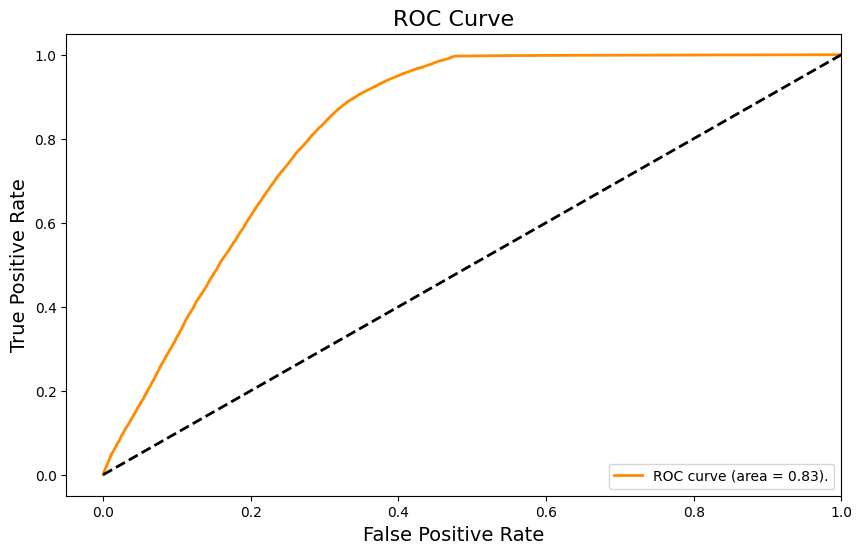

In [39]:

#for i in range (1, 2):
#    poly = PolynomialFeatures(i)
    #X_training_poly = poly.fit_transform(X_training)
X_training_poly = X_training
regL2_full = logistic_regression_CV(X_training_poly, Y_training, cv=5, penalty='l1', solver="liblinear", class_weight='balanced')
evaluate_model(regL2_full, (X_training_poly, Y_training), train_test_dataset='Train', print_report=True, threshold=0.6)
y_pred_proba_training = regL2_full.predict_proba(X_training_poly)
plot_roc_curve(Y_training, y_pred_proba_training)
#poly = PolynomialFeatures(2)
#X_training_poly = poly.fit_transform(X_training)
#regL2_full = logistic_regression_CV(X_training_poly, Y_training, cv=5, penalty='l1', solver="liblinear", class_weight='balanced')

In [41]:
X_test_poly = X_test#poly.fit_transform(X_test)
evaluate_model(regL2_full, (X_test_poly, Y_test), train_test_dataset='Test', print_report=True, threshold=0.3)


Accuracy: 0.730
Log-Loss: 0.473
Test Report:
              precision    recall  f1-score   support

           0       0.99      0.53      0.69     40274
           1       0.52      0.99      0.68     20874

    accuracy                           0.69     61148
   macro avg       0.76      0.76      0.69     61148
weighted avg       0.83      0.69      0.69     61148



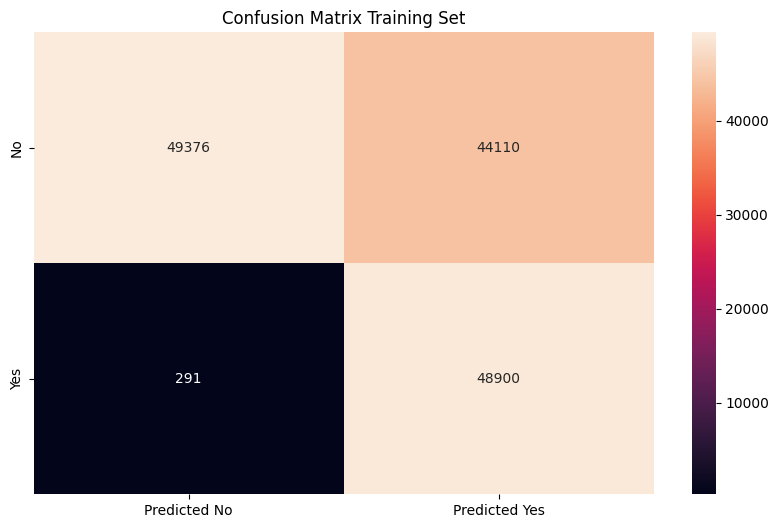

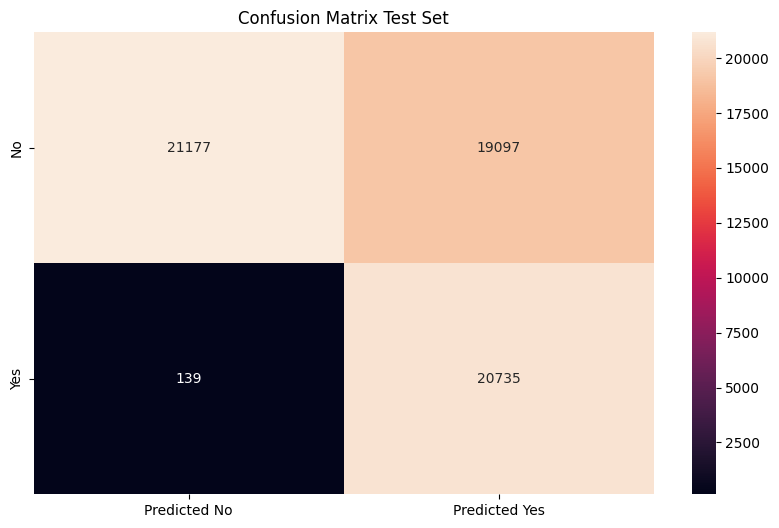

In [43]:
y_pred_proba_training = regL2_full.predict_proba(X_training_poly)
y_pred_training = np.where(y_pred_proba_training[:,1] > 0.3, 1, 0)
confusion_matrix_train = confusion_matrix(Y_training, y_pred_training)

y_pred_proba_test = regL2_full.predict_proba(X_test_poly)
y_pred_test = np.where(y_pred_proba_test[:,1] > 0.3, 1, 0)
confusion_matrix_test = confusion_matrix(Y_test, y_pred_test)


plot_confusion_matrix(confusion_matrix_train, "Confusion Matrix Training Set")
plot_confusion_matrix(confusion_matrix_test, "Confusion Matrix Test Set")

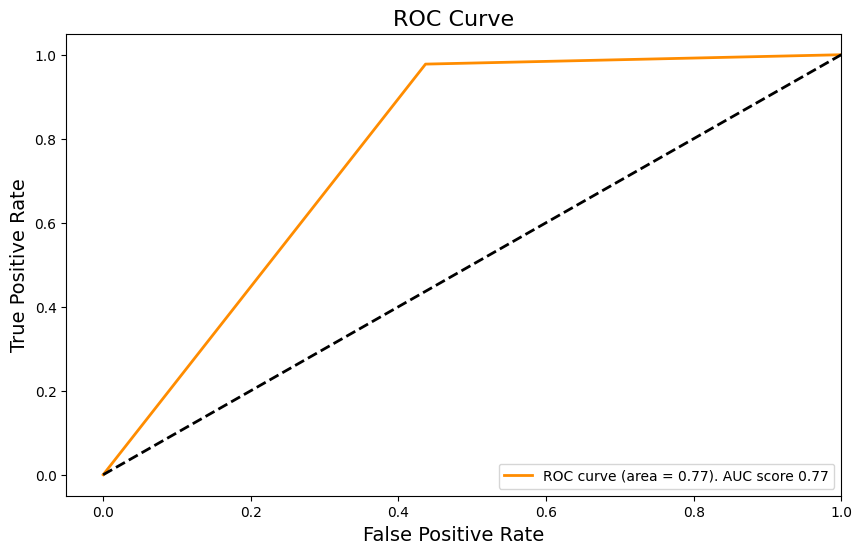

In [330]:
plot_roc_curve(Y_test, y_pred_proba_test, multiclass='ovo', average='macro')
